## importar librerias

In [1]:
import cv2
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

## ir al directorio de las fotos y tomas los nombres de las carpetas

In [3]:
local_path = os.getcwd()
fotos_path = os.path.join(local_path, 'fotos-training')
fotos_path = os.path.join(fotos_path, 'training')
labels = os.listdir(fotos_path)
labels_path = []
for l in labels:
    labels_path.append(os.path.join(fotos_path,l))

## Aca renombre todas las imagenes de cada carpeta porque eran una caos

In [4]:
os.listdir(labels_path[0])
nombre_fotos = []
for l in labels_path:
    fotos = os.listdir(l)
    i = 1
    for f in fotos:
        try:
            os.rename(os.path.join(l,f), os.path.join(l,f'{i}.jpg'))
            i +=1
        except:
            i +=1
            pass

## Cargo las imagenes, calculo los momentos y armo un dataframe con estos

In [10]:
Hu_moments = []
for l in labels_path:
        for f in os.listdir(l):
            img = cv2.imread(os.path.join(l,f))
            im = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            _,im = cv2.threshold(im, 160, 200, cv2.THRESH_BINARY)
            HU = cv2.HuMoments(cv2.moments(im)).ravel().tolist()
            HU.append(os.path.basename(os.path.normpath(l)))
            Hu_moments.append(HU)

In [11]:
columns = ['m1','m2','m3','m4','m5','m6','m7','p-p-t']
df = pd.DataFrame(Hu_moments,columns=columns)
df.to_csv('huMoments.csv')

In [12]:
df.describe()

,m1,m2,m3,m4,m5,m6,m7
count,655.000000,6.550000e+02,6.550000e+02,6.550000e+02,6.550000e+02,6.550000e+02,6.550000e+02
mean,0.002215,3.634472e-06,6.328612e-09,4.664329e-09,4.004885e-17,9.461522e-12,2.977034e-18
std,0.000593,2.717045e-06,4.749065e-09,3.808029e-09,2.349588e-16,1.094785e-11,1.539618e-17
min,0.001081,2.803461e-07,3.484630e-11,6.743965e-13,-6.032775e-18,-4.826957e-14,-2.166980e-16
25%,0.002113,2.851386e-06,5.655355e-09,4.109890e-09,2.039440e-17,7.203421e-12,4.084767e-19
50%,0.002188,3.250321e-06,6.432334e-09,4.621543e-09,2.519665e-17,8.455965e-12,1.769308e-18
75%,0.002366,3.959483e-06,7.313567e-09,5.309527e-09,3.251400e-17,1.007181e-11,4.342977e-18
max,0.005708,2.517869e-05,9.116430e-08,7.298453e-08,5.953107e-15,1.864987e-10,1.258724e-16


In [48]:
grupos = df.groupby('p-p-t')
grupos.mean()

,m1,m2,m3,m4,m5,m6,m7
p-p-t,,,,,,,
papel2,0.004793,0.000007,1.960983e-07,8.599380e-08,2.810455e-14,1.585688e-10,-3.496837e-14
piedras2,0.006785,0.000014,3.933911e-07,2.154200e-07,1.921634e-13,7.855409e-10,-7.051951e-14
tijeras2,0.005988,0.000014,1.654262e-07,8.057360e-08,8.407137e-14,5.023353e-10,-2.481100e-14


## separo los datos segun sean los de entrada o salida

In [13]:
x_columns = [x for x in columns if x != 'p-p-t']
x = df[x_columns]
y = df['p-p-t']

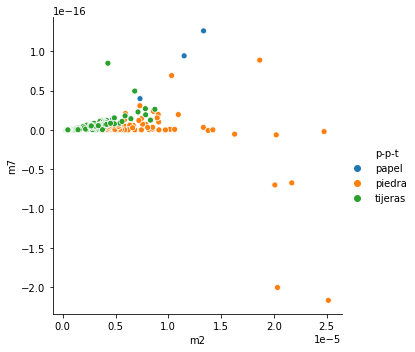

In [14]:
sns.relplot(data=df,x='m2',y='m7', hue='p-p-t')

## Separamos la parte de train de la de test

In [87]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=31)

## Escalar los datos: al haber tanta diferencia entro los distintos parametros los escalamos todos asi ninguno tiene mas peso que el otro

In [19]:
standar = StandardScaler()
scaler = standar.fit(x_train)
x_train_new = scaler.transform(x_train)
x_test_new = scaler.transform(x_test)

In [20]:
x_train_new

array([[-0.13760718, -0.20349091, -0.17438702, ..., -0.07761162,
        -0.16878898, -0.28910941],
       [ 0.26598088,  0.16966419,  0.45539721, ...,  0.05492639,
         0.48521624, -0.22462997],
       [ 3.84527721,  4.81248415, -0.71762499, ..., -0.12871608,
         0.19110418, -0.89370435],
       ...,
       [-0.12698775, -0.1762237 , -0.05241504, ..., -0.05427032,
        -0.05367948, -0.29442577],
       [-0.0507954 , -0.14094715, -0.03803836, ..., -0.04888053,
        -0.01315004, -0.15376059],
       [-0.19251374, -0.27363773,  0.00748468, ..., -0.06262371,
        -0.13709883, -0.07332671]])

## Cuando vi que el modelo podia funcionar arme la grid para probar distintos parametros

In [21]:
params_grid =[
    {
        'kernel':['rbf'],
        'gamma':[1e-4,1e-3,1e-2, 0.1, 0.2, 0.5],
        'C':[1,10,100,1000]
    },
    {
        'kernel':['linear'],
        'C':[1,10,100,1000]
    }
]
gscv = GridSearchCV(svm.SVC(),param_grid=params_grid, cv=5)

In [85]:
model = gscv.fit(x_train,y_train)
clasifier = model.best_estimator_

## Analizo los resultados de la grid Search

In [86]:
print(model.best_params_)
print(model.best_score_)
#print(model.cv_results_)

{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.34215625644197073


In [27]:
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for m, s, p in zip(means, stds, params):
    print(f"{m} (+/-{2*s}) para {p}")

0.34215625644197073 (+/-0.009215863059570197) para {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.505256648113791 (+/-0.0864846191572778) para {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.5724386724386725 (+/-0.07812179166803189) para {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.6702535559678416 (+/-0.11871817494135009) para {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.7007008864151721 (+/-0.10086455169766792) para {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
0.7332714904143476 (+/-0.09769114331708906) para {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.5011956297670583 (+/-0.09384610373048607) para {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.5643166357452071 (+/-0.08685529191788621) para {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.6539682539682541 (+/-0.13879625769352252) para {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.7556173984745413 (+/-0.12565396269973916) para {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.778066378066378 (+/-0.0890670107860354) para {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
0.8148

## Hago las predicciones usando el mejor estimador y analizo los resultados

In [76]:
y_pred = clasifier.predict(x_test)

In [77]:
print(classification_report(y_test, y_pred,labels=labels))

              precision    recall  f1-score   support

       papel       0.35      1.00      0.52        57
      piedra       0.00      0.00      0.00        55
     tijeras       0.00      0.00      0.00        52

    accuracy                           0.35       164
   macro avg       0.12      0.33      0.17       164
weighted avg       0.12      0.35      0.18       164



C:\Users\garel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


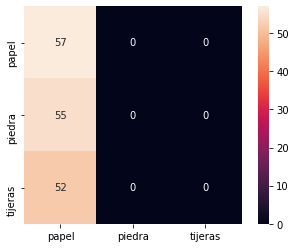

In [78]:
mat = confusion_matrix(y_test,y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, xticklabels=labels, yticklabels=labels)

In [31]:
print(accuracy_score(y_pred,y_test))

0.8414634146341463


## Guardamos el modelo asi no hay que seguir entrenandolo cada vez

In [32]:
with open('modelHU-SVM.pickle', 'wb') as f:
    pickle.dump(clasifier,f)

In [33]:
with open('estandarizador-HU.pickle', 'wb') as f:
    pickle.dump(scaler, f)

#### en caso que lo queramos importar de nuevo

In [28]:
with open('modelHU-SVM.pickle', 'rb') as f:
    clasifier = pickle.load(f)

In [37]:
y_test

165      papel
199      papel
638    tijeras
418     piedra
277     piedra
        ...   
434     piedra
48       papel
371     piedra
198      papel
601    tijeras
Name: p-p-t, Length: 164, dtype: object

In [44]:
x_test_new[0].reshape(1,-1)

array([[-0.07568388, -0.23859829,  0.01492058, -0.12397412, -0.07758913,
        -0.20503011,  0.01431107]])

In [49]:
clasifier.predict(x_test_new[163].reshape(1,-1))

array(['tijeras'], dtype=object)

In [95]:
test_Hu[0]

array([ 0.6572683 ,  0.59250759,  0.42583372,  0.62994259,  0.04983376,
        0.63039509, -0.44457687])

In [93]:
scaler.transform(x_test.iloc[0:1])

array([[-0.07568388, -0.23859829,  0.01492058, -0.12397412, -0.07758913,
        -0.20503011,  0.01431107]])

In [56]:
local_path = os.getcwd()
fotos_prueba = os.path.join(local_path,'prueba')
Hu_moments = []
for i in os.listdir(fotos_prueba):
    true_path = os.path.join(fotos_prueba, i)
    img = cv2.imread(true_path)
    im = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    _,im = cv2.threshold(im, 160, 200, cv2.THRESH_BINARY)
    HU = cv2.HuMoments(cv2.moments(im)).ravel().tolist()
    Hu_moments.append(HU)


In [66]:
y_test.iloc[0]

'papel'

In [98]:
fotos_prueba = os.path.join(local_path,'fotos-training')
fotos_prueba = os.path.join(local_path,'fotos-training')
fotos_prueba = os.path.join(local_path,'42.jpg')
img = cv2.imread(true_path)
im = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
_,im = cv2.threshold(im, 160, 200, cv2.THRESH_BINARY)
HU = cv2.HuMoments(cv2.moments(im)).ravel()

In [99]:
scaler.transform(HU.reshape(1,-1))

array([[ 1.10665883,  0.4131621 ,  1.59202196,  0.63696431,  0.07310498,
         0.55009919, -4.26097401]])